The following are key descriptions of analytic scores that are being used to hopefully identify key behavioural archetypes within the wallet data:

 - **Behavioural Volatility Score**: The Behavioural Volatility Score quantifies how variable or erratic a wallet's transaction behavior is over time. It measures the inconsistency in transaction amounts and timing for each wallet. High scores indicate wallets with irregular, unpredictable activity, while low scores suggest regular, stable transaction patterns. The score is typically derived using statistical analysis of transaction histories, such as calculating the standard deviation or other measures of dispersion in transaction frequency and amounts. This helps identify users whose behavior deviates from the norm, which can be useful for segmentation, risk assessment, or anomaly detection. 

- **Revenue Proxy Score**: estimates the potential revenue contribution of each wallet by combining several aspects of user activity. It is calculated as a weighted sum of three main components: transaction activity (frequency of transactions multiplied by their average value), DEX/DeFi engagement (the number of decentralized exchange and DeFi events, weighted by average transfer value), and bridge activity (the total volume transferred via bridges). By aggregating these factors, the score highlights wallets that are likely to be high-value users based on their transaction patterns and engagement with DeFi and cross-chain services.

- **Cross Domain Engagement Score**: The cross domain engagement score is a metric that quantifies how diversely a cryptocurrency wallet interacts across different event types or domains. It is calculated using Shannon entropy, which measures the unpredictability or diversity of event participation for each wallet. A score near 1 means the wallet's activity is evenly spread across many event types (high engagement diversity). A score near 0 means the wallet's activity is concentrated in few or just one event type (low engagement diversity)

- **Interaction Mode Score**: A median value is produced for each of DEX_EVENTS, CEX_EVENTS, BRIDGE_EVENTS and DEFI_EVENTS from clustering results where a cluster median for each feature is selected from the most prominant cluster for that event type. The distance score measures how much a wallet's behavior deviates from the median, after normalizing for feature variability and weighting by the wallet's activity profile. A higher score means the wallet acts more unusually compared to typical behavior, with the score reflecting both the size and importance of these differences. The typical behaviour being a value of an EVENT feature engagement that is prominant and high.

- **Activity-Based Clustering (UMAP + HDBSCAN)**: Groups wallets into clusters based on their activity patterns using a two-step pipeline: UMAP for dimensionality reduction and HDBSCAN for density-based clustering. This model reveals natural groupings or archetypes in the user base, helping to identify segments with similar behaviors. 


The best possible way to identify groups in the data is to think of potential "behavioural archetypes" that are possible given what all the analytic scores do and then from there you can visualise and look into these scores in a cross examination to see if these archetypes exist in any way, shape or form.

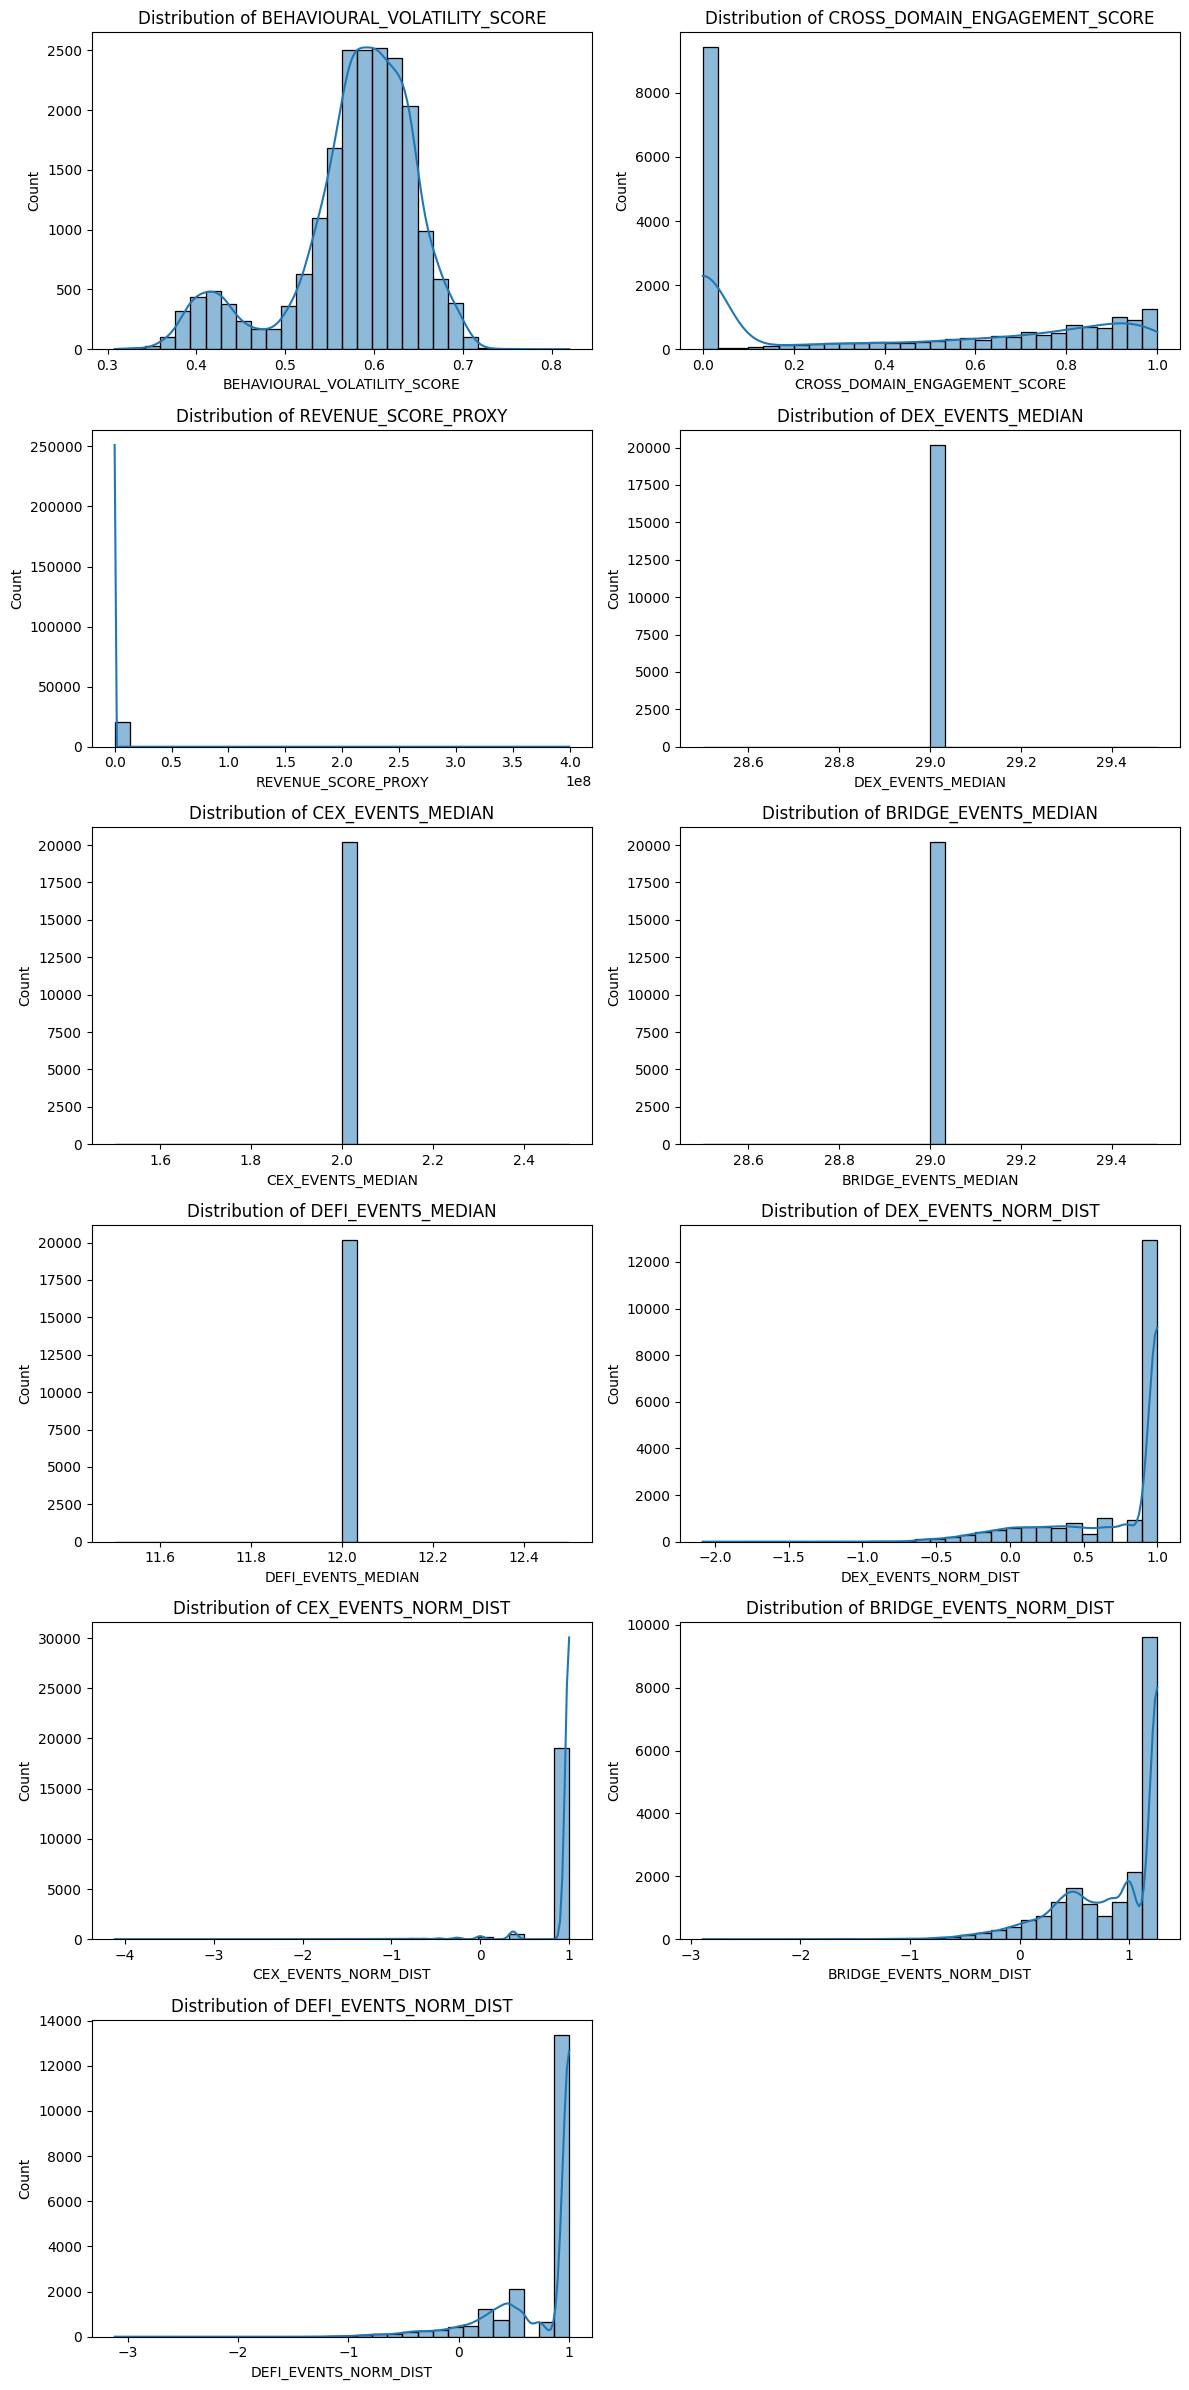

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
scores_path = '../data/processed_data/merged_analytic_scores.csv'
df = pd.read_csv(scores_path)

# Get all columns after 'activity_cluster_label'
start_col = df.columns.get_loc('activity_cluster_label') + 1
score_cols = df.columns[start_col:]

# Plot distributions for each analytic score column
df_scores = df[score_cols]
num_cols = len(score_cols)
fig, axes = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2, figsize=(12, 4 * ((num_cols + 1) // 2)))
axes = axes.flatten()

for i, col in enumerate(score_cols):
    sns.histplot(df_scores[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Stable high-value traders: 297 wallets (1.5% of total)


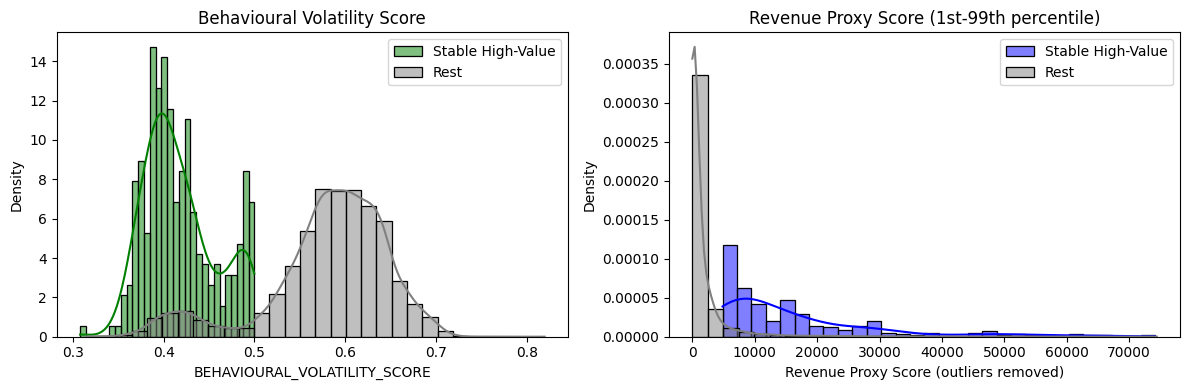

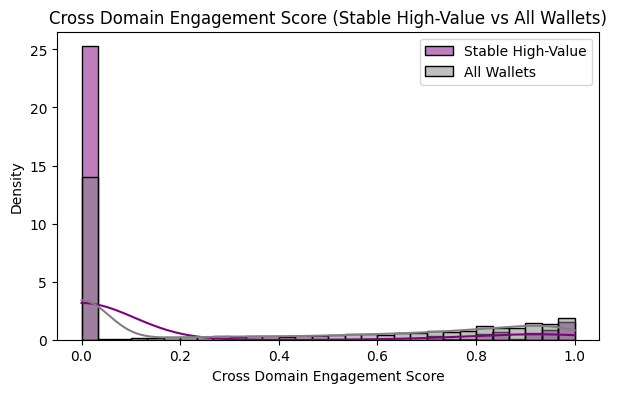

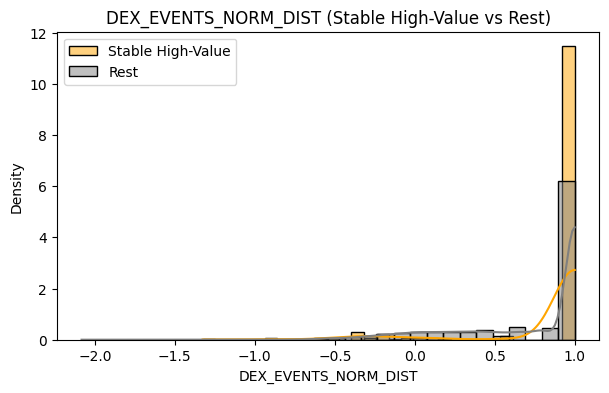

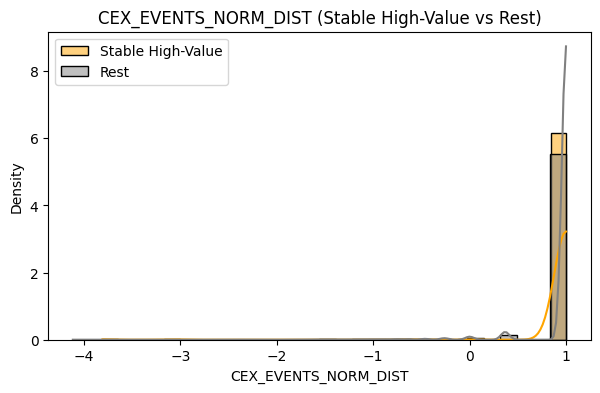

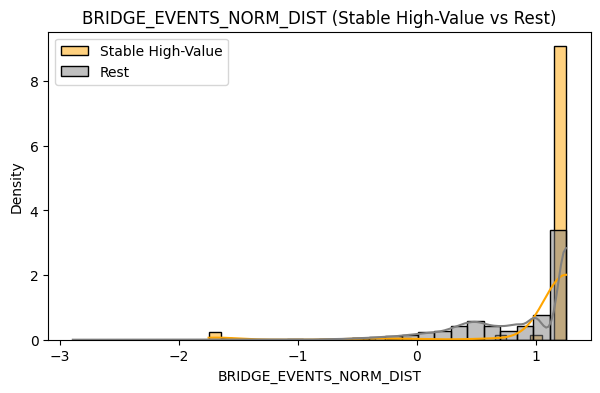

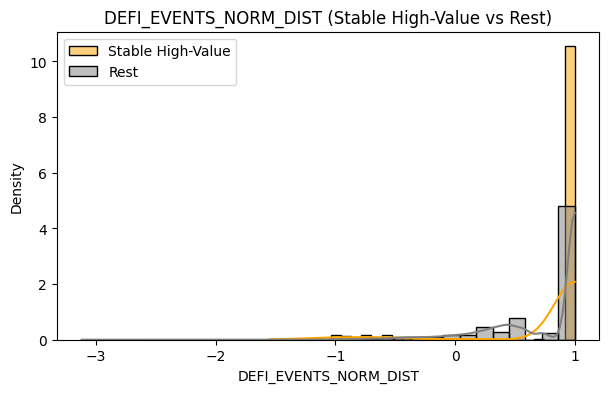

In [12]:
# Identify 'stable high-value traders' and compare to rest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define score columns
vol_col = 'BEHAVIOURAL_VOLATILITY_SCORE'
rev_col = 'REVENUE_SCORE_PROXY'
cross_col = 'CROSS_DOMAIN_ENGAGEMENT_SCORE'
im_dist_cols = [col for col in df.columns if col.endswith('_NORM_DIST')]

# Calculate thresholds
vol_thresh = 0.5  # Set volatility threshold to 0.5
rev_thresh = np.percentile(df[rev_col], 90)  # Set revenue threshold to 90th percentile

# Select group: volatility < 0.5, high revenue
stable_high_value = df[(df[vol_col] < vol_thresh) & (df[rev_col] >= rev_thresh)]
rest = df[~((df[vol_col] < vol_thresh) & (df[rev_col] >= rev_thresh))]

print(f"Stable high-value traders: {len(stable_high_value)} wallets ({len(stable_high_value)/len(df)*100:.1f}% of total)")

# Remove top and bottom 1% outliers for revenue proxy score
rev_low, rev_high = np.percentile(df[rev_col], [1, 99])
shv_rev = stable_high_value[(stable_high_value[rev_col] >= rev_low) & (stable_high_value[rev_col] <= rev_high)]
rest_rev = rest[(rest[rev_col] >= rev_low) & (rest[rev_col] <= rev_high)]

# 1. Distribution of volatility and revenue (comparison)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(stable_high_value[vol_col], color='green', label='Stable High-Value', ax=axes[0], kde=True, bins=30, stat='density')
sns.histplot(rest[vol_col], color='grey', label='Rest', ax=axes[0], kde=True, bins=30, stat='density', alpha=0.5)
axes[0].set_title('Behavioural Volatility Score')
axes[0].legend()

sns.histplot(shv_rev[rev_col], color='blue', label='Stable High-Value', ax=axes[1], kde=True, bins=30, stat='density')
sns.histplot(rest_rev[rev_col], color='grey', label='Rest', ax=axes[1], kde=True, bins=30, stat='density', alpha=0.5)
axes[1].set_title('Revenue Proxy Score (1st-99th percentile)')
axes[1].set_xlabel('Revenue Proxy Score (outliers removed)')
axes[1].legend()
plt.tight_layout()
plt.show()

# 2. Cross Domain Engagement Score: compare group to whole dataset
plt.figure(figsize=(7,4))
sns.histplot(stable_high_value[cross_col], color='purple', kde=True, bins=30, label='Stable High-Value', stat='density')
sns.histplot(df[cross_col], color='grey', kde=True, bins=30, label='All Wallets', alpha=0.5, stat='density')
plt.title('Cross Domain Engagement Score (Stable High-Value vs All Wallets)')
plt.xlabel('Cross Domain Engagement Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 3. Interaction Mode Distance Scores: compare group vs rest
for col in im_dist_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(stable_high_value[col], color='orange', kde=True, bins=30, label='Stable High-Value', stat='density')
    sns.histplot(rest[col], color='grey', kde=True, bins=30, label='Rest', alpha=0.5, stat='density')
    plt.title(f'{col} (Stable High-Value vs Rest)')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


All visualisations below use density (rather than count) on the y-axis. Density plots show the proportion of data in each bin, making it easier to compare distributions between groups of different sizes. This is especially useful here, as the 'stable high-value trader' group is much smaller than the rest of the dataset, so comparing densities rather than raw counts gives a fairer view of how the distributions differ.